# Titanic problem

## Use neural network approch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
train_df = pd.read_csv('train.csv')

## Convert data into numerals

In [3]:
train_df = train_df.dropna(subset=['Age'])
train_df['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
train_df = pd.get_dummies(train_df, columns=['Embarked'])

X_df = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
scaler = MinMaxScaler()
y_df = train_df[['Survived']]
X_keys = list(X_df.keys())
X_values = scaler.fit_transform(X_df)
y_values = np.squeeze(y_df.values)
len(X_values)

714

## Prepare the training set and the test set

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
X_train = torch.from_numpy(X_values).float()
y_train = torch.from_numpy(y_values)#.float()
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testsize = int(len(trainset)*.25)
trainset, testset = torch.utils.data.random_split(trainset, [len(trainset)-testsize, testsize])
valsize = int(len(trainset)*.2)
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset)-valsize, valsize])
print(len(trainset), len(valset), len(testset))

429 107 178


In [6]:
BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

## Define the neural network

In [7]:
hidden_size = 128

model = nn.Sequential(
    nn.Linear(len(X_train[0]), hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 2)).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr)

In [9]:
def train(model, dataloaders, otpimizer, criterion, num_epochs, meta, device):
    for epoch in range(1, num_epochs+1):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            #with torch.set_grad_enabled(phase == "train"), tqdm(total=len(dataloaders[phase]), unit="batch") as pbar:
            with torch.set_grad_enabled(phase == "train"):
                loss_sum = 0
                total = 0
                #pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                for batch_idx, (xs, ys) in enumerate(dataloaders[phase]):
                    xs, ys = xs.to(device), ys.to(device)
                    optimizer.zero_grad()
                    output = model(xs)
                    loss = criterion(output, ys)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    total += xs.size(0)
                    loss_sum += loss.item() * xs.size(0) 

                    running_loss = loss_sum / total

                    #pbar.set_postfix({"loss":running_loss})
                    #pbar.update(1)
                if phase == "train":
                    meta['losses'].append(running_loss)
                    if epoch % 1000 == 0:
                        print('loss', running_loss)
            if phase == "train" and epoch % 1000 == 0:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] / 2

In [10]:
dataloaders = {"train":trainloader, "val":valloader}
meta = { 'losses': [] }
num_epochs = 10000

train(model, dataloaders, optimizer, criterion, num_epochs, meta, device)

loss 0.2771000777369057
loss 0.25462186159370664
loss 0.24714579728447197
loss 0.2424658248960833
loss 0.24067415359553757
loss 0.23965159405917277
loss 0.23925901008096886
loss 0.23902928342908134
loss 0.23892695283070034
loss 0.23886100034335833


## Show losses during the training

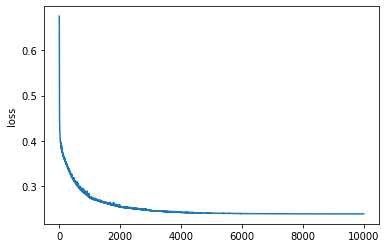

In [11]:
import matplotlib.pyplot as plt

losses = meta['losses']

plt.plot(range(len(losses)), losses)
plt.ylabel('loss')
plt.show()

## Evaluation

In [12]:
model.eval()
total = 0
correct = 0
for xs, ys in testloader:
    xs, ys = xs.to(device), ys.detach().numpy()
    output = F.softmax(model(xs), dim=1)
    y_pred = np.array([int(p[0] < 0.5) for p in output.detach().numpy()])
    total += len(ys)
    correct += np.sum(y_pred == ys)
print(f'acc = {round(correct/total, 2)}')

acc = 0.79
